**Objetivo**

Este notebook tem como objetivo o desenvolvimento de modelos preditivos de machine learning com o objetivo de estimar pressão e temperatura de um gás através de seu respectivo espectro de alta resolução, ou seja, teremos acesso às transições rotacionais.

**Como**


Para cada espectro, iremos separar as raias espectrais e realizar o ajuste das mesmas através do perfil de Voigt.

Os parâmetros obtidos pelo ajuste serão as features que utilizaremos para treinar os modelos. Cada conjunto de parâmetros terá associado uma temperatura e uma pressão.

Utilizaremos os espectros da molécula de ácido clorídrico (HCl) por dois motivos:

1. Temos 14 espectros reais variando em temperatura e pressão.

2. Conseguimos simular esses espectros via HITRAN alterando pressão e temperatura.


Abordaremos duas metodologias:

1. Treinar e testar modelos em espectros simulados e validar em espectros reais

2. Treinar e validar somente em espectros reais.


No treinamento, iremos separar algumas linhas, obteremos os parâmetros de todas e avaliaremos os modelos. Em um teste mais realista, obteremos um espectro, faremos a extração das raias e a obtenção dos parâmetros via ajuste não linear. Para cada linha do espectro, teremos uma estimativa de pressão e temperatura.  Após todas as linhas serem ingeridas no modelo, teremos uma lista com diversas pressões e temperaturas. Essa lista será tratada em um pós-processamento, calcularemos o valor médio ou mediano e em torno desse teremos um intervalo de confiança, essa abordagem será realizada para pressão e temperatura.


**Motivação:**

Gases constituidos por moléculas de HCl são altamente corrosivos.  Ao realizarmos experimentos com esse tipo de gás, grande parte do setup experimental é degradado devido a reatividade desse ácido. A depender do estudo a ser feito, é necessário termos ciência da temperatura e pressão do gás, como exemplo, temos que o alargamento das linhas espectrais está associado à pressão ao qual o gás se encontra. No entanto, equipamentos de medidas como termometros e sensores de pressão não são baratos e perde-los em um experimento envolvendo gases corrosivos não é vantajoso. Desse modo, podemos utilizar aprendizado de maquina para estimar as pressões e temperaturas de nossos gases baseando-nos em seus respectivos espectros.

Muitas vezes é dificil conseguirmos uma quantidade suficiente de espectros, portanto, uma maneira de mitigarmos esse problema é por meio de simulações.

Por esse motivo, teremos duas metodologias. Além de apenas obter uma estimativa de pressão e temperatura, desejamos também saber se é possível utilizarmos espectros simulados para treinar esses modelos e depois aplica-los em situações reais. 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import seaborn as sns

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from SpectraHitran.SpectraGenerator.spectragenerator import SpectraGenerator
from SpectraHitran.SpectraProcessing.spectraprocessing import branchClassification, plotSpectrum
from SpectraHitran.SpectraFit.spectrafit import multipleLineFit

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

HAPI version: 1.2.2.3
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [2]:
def r2Filter(df,limiar):
    return df.query(f'r2 > {limiar}')

def crossVal(splits = 5, X = None, y = None, model = None):
 

    kf = KFold(n_splits = splits, random_state = 42, shuffle = True)

    folds = kf.split(X, y)


    mse_pressure = 0
    mse_temperature = 0
    mae_pressure = 0
    mae_temperature = 0
    
    for i, (itrain, itest) in enumerate(folds):

        X_train = X.iloc[itrain, :]
        X_test  = X.iloc[itest, :]

        y_train = y.iloc[itrain, :]
        y_test  = y.iloc[itest , :]


        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)



        mse_pressure  += root_mean_squared_error(y_test['pressure'], y_hat[:, 1])
        mae_pressure  += mean_absolute_error(y_test['pressure'], y_hat[:, 1])

        mse_temperature += root_mean_squared_error(y_test['temperature'], y_hat[:, 0])
        mae_temperature += mean_absolute_error(y_test['temperature'], y_hat[:, 0])



    return mse_temperature/splits, mae_temperature/splits, mse_pressure/splits, mae_pressure/splits

def loss(y_real, y_pred):
    mse_pressure  = root_mean_squared_error(y_real['pressure'], y_pred[:, 1])
    mae_pressure  = mean_absolute_error(y_real['pressure'], y_pred[:, 1])

    mse_temperature = root_mean_squared_error(y_real['temperature'], y_pred[:, 0])
    mae_temperature = mean_absolute_error(y_real['temperature'], y_pred[:, 0])

    return mae_temperature, mse_temperature, mae_pressure, mse_pressure


def bootstrap_normal_ci(predictions, n_bootstrap=10000, ci= 95):
    """
    Calcula um intervalo de confiança normal para a média das previsões usando bootstrap.

    Parameters:
        predictions (array-like): Lista com as estimativas do modelo para um espectro.
        n_bootstrap (int): Número de amostras bootstrap.
        ci (float): Nível de confiança (ex: 95 para um intervalo de 95%).

    Returns:
        tuple: (média estimada, limite inferior, limite superior)
    """
    medias_bootstrap = []

    for _ in range(n_bootstrap):
        sample = np.random.choice(predictions, size=len(predictions), replace=True)
        medias_bootstrap.append(np.mean(sample))

    mean_pred = np.mean(medias_bootstrap)  # Média das médias bootstrap
    std_pred = np.std(medias_bootstrap, ddof=1)  # Desvio padrão das médias bootstrap
    se_pred = std_pred / np.sqrt(n_bootstrap)

    z_score = norm.ppf(1 - (1 - ci / 100) / 2)  # Quantil da normal (ex: 1.96 para 95%)

    lower = mean_pred - z_score * se_pred
    upper = mean_pred + z_score * se_pred

    return mean_pred, lower, upper


def validacaoCruzada(X_train, y_train, model, preprocessor):

    results = {'model': [],
        'mae_temperature': [],
        'mse_temperature': [],
        'mae_pressure':[],
        'mse_pressure':[]}
    

    for name, model in model.items():

            step = [('preprocessor', preprocessor),
                    ('Model', model)]
            
            model_pipe = Pipeline(steps = step)

            print(name)
            mse_temp, mae_temp, mse_pres, mae_pres  = crossVal(X = X_train, y = y_train, model = model_pipe)

            results['model'].append(name)
            results['mae_temperature'].append(mae_temp)
            results['mse_temperature'].append(mse_temp)
            results['mae_pressure'].append(mae_pres)
            results['mse_pressure'].append(mse_pres)

    return pd.DataFrame(results)

carregando dados sintéticos e reais (prod)

In [3]:
train = pd.read_csv('../database/lines/lines_train.csv')
test  = pd.read_csv('../database/lines/lines_test.csv')
prod = pd.read_csv('../database/lines/lines_prod.csv')


prod = prod.query('model == "Voigt"').reset_index(drop=True)



train['pressure'] = train['pressure'] * 1013
test['pressure'] = test['pressure'] * 1013

Selecionando somente os melhors ajustes dos dados sintéticos

In [4]:
train = r2Filter(train, 0.9)
test = r2Filter(test, 0.9)

Separando as informações uteis que serão utilizadas na modelagem

In [5]:
train = train[['center','amplitude','sigma','gamma','fwhm','height', 'temperature', 'pressure']]
test = test[['center','amplitude','sigma','gamma','fwhm' ,'height','temperature', 'pressure']]

prod = prod[['center','amplitude','sigma','gamma','fwhm','height', 'temperature', 'pressure']]

definindo os modelos com diferentes estrategias

In [6]:
models_separados = {
    'linear_regression': MultiOutputRegressor(LinearRegression()),
    'lasso': MultiOutputRegressor(Lasso(max_iter = 10000)),
    'ridge': MultiOutputRegressor(Ridge()),
    'knn': MultiOutputRegressor(KNeighborsRegressor()),
    'random_forest': MultiOutputRegressor(RandomForestRegressor(random_state = 0)),
    'decision_tree': MultiOutputRegressor(DecisionTreeRegressor(random_state = 0 )),
    #'svm': MultiOutputRegressor(SVR()),
    'lgbm': MultiOutputRegressor(LGBMRegressor(force_col_wise=True, verbose = -1)),
    'xgb': MultiOutputRegressor(XGBRegressor())
    
}

models_chain_temperature_first = {
    'linear_regression': RegressorChain(LinearRegression(), order = [0,1]),
    'lasso': RegressorChain(Lasso(max_iter = 10000), order = [0,1]),
    'ridge': RegressorChain(Ridge(), order = [0,1]),
    'knn': RegressorChain(KNeighborsRegressor(), order = [0,1]),
    'random_forest': RegressorChain(RandomForestRegressor(random_state = 0), order = [0,1]),
    'decision_tree': RegressorChain(DecisionTreeRegressor(random_state = 0), order = [0,1]),
    #'svm': RegressorChain(SVR(), order = [0,1]),
    'lgbm': RegressorChain(LGBMRegressor(force_col_wise=True, verbose = -1), order = [0,1]),
    
}

models_chain_pressure_first = {
    'linear_regression': RegressorChain(LinearRegression(), order = [1, 0]),
    'lasso': RegressorChain(Lasso(max_iter = 10000), order = [1,0]),
    'ridge': RegressorChain(Ridge(), order = [1,0]),
    'knn': RegressorChain(KNeighborsRegressor(), order = [1,0]),
    'random_forest': RegressorChain(RandomForestRegressor(random_state = 0), order = [1,0]),
    'decision_tree': RegressorChain(DecisionTreeRegressor(random_state = 0), order = [1,0]),
    #'svm': RegressorChain(SVR(), order = [1,0]),
    'lgbm': RegressorChain(LGBMRegressor(force_col_wise=True, verbose = -1), order = [1,0]),
    
}

# Metodologia 1

In [7]:
X_train = train.drop(columns=['temperature','pressure'])
y_train = train[['temperature','pressure']]

X_test = test.drop(columns=['temperature','pressure'])
y_test = test[['temperature','pressure']]

In [8]:
preprocessor = Pipeline(steps = [('scaler', StandardScaler())])

print('-----Pressão first------')
pressure_first = validacaoCruzada(X_train, y_train, models_chain_pressure_first,preprocessor)
print('\n------Temperature first------')
temperature_first = validacaoCruzada(X_train, y_train, models_chain_temperature_first,preprocessor)
print('\n------Separated------')
separated = validacaoCruzada(X_train, y_train, models_separados,preprocessor)

pressure_first['type'] = 'pressure_first'
temperature_first['type'] = 'temperature_first'
separated['type'] = 'separated'

results_baseline = pd.concat([pressure_first,temperature_first,separated]).reset_index(drop=True)

-----Pressão first------
linear_regression
lasso
ridge
knn
random_forest
decision_tree
lgbm

------Temperature first------
linear_regression
lasso
ridge
knn
random_forest
decision_tree
lgbm

------Separated------
linear_regression
lasso
ridge
knn
random_forest
decision_tree
lgbm
xgb


In [9]:
preprocessor = Pipeline(steps = [('feature_eng',PolynomialFeatures()),('scaler', StandardScaler())])

print('-----Pressão first------')
pressure_first = validacaoCruzada(X_train, y_train, models_chain_pressure_first, preprocessor)
print('\n------Temperature first------')
temperature_first = validacaoCruzada(X_train, y_train, models_chain_temperature_first,preprocessor)
print('\n------Separated------')
separated = validacaoCruzada(X_train, y_train, models_separados,preprocessor)

pressure_first['type'] = 'pressure_first'
temperature_first['type'] = 'temperature_first'
separated['type'] = 'separated'

results = pd.concat([pressure_first,temperature_first,separated]).reset_index(drop=True)

-----Pressão first------
linear_regression
lasso
ridge
knn
random_forest
decision_tree
lgbm

------Temperature first------
linear_regression
lasso
ridge
knn
random_forest
decision_tree
lgbm

------Separated------
linear_regression
lasso
ridge
knn
random_forest
decision_tree
lgbm
xgb


In [10]:
display(results_baseline.sort_values(by='mae_temperature'))

display(results.sort_values(by='mae_temperature'))

,model,mae_temperature,mse_temperature,mae_pressure,mse_pressure,type
11,random_forest,3.949873,7.744026,6.995004,10.391252,temperature_first
18,random_forest,3.949873,7.744026,7.623373,11.582200,separated
19,decision_tree,4.686913,11.166747,10.157183,16.880517,separated
12,decision_tree,4.686913,11.166747,9.865106,16.555942,temperature_first
21,xgb,5.787020,8.750275,8.795224,12.177426,separated
4,random_forest,7.817852,12.495680,7.623373,11.582200,pressure_first
5,decision_tree,9.318584,16.919260,10.157183,16.880517,pressure_first
13,lgbm,9.512014,12.979132,10.727500,14.763804,temperature_first
20,lgbm,9.512014,12.979132,11.580636,15.685930,separated
10,knn,10.311055,15.234905,83.829386,115.887649,temperature_first


,model,mae_temperature,mse_temperature,mae_pressure,mse_pressure,type
11,random_forest,4.253708,8.133249,7.618158,11.660693,temperature_first
18,random_forest,4.253708,8.133249,8.016085,12.615897,separated
19,decision_tree,4.834137,11.411199,10.749774,18.316260,separated
12,decision_tree,4.834137,11.411199,10.660162,18.586567,temperature_first
21,xgb,6.053245,9.111719,9.512668,13.176658,separated
4,random_forest,7.579965,12.263558,8.016085,12.615897,pressure_first
5,decision_tree,9.227592,17.047392,10.749774,18.316260,pressure_first
13,lgbm,9.645704,13.171199,11.051826,15.169666,temperature_first
20,lgbm,9.645704,13.171199,11.727128,15.830946,separated
10,knn,10.606325,15.708229,66.349050,92.081294,temperature_first


In [35]:
model = RegressorChain(RandomForestRegressor(random_state = 0), order = [0,1])
step = [('Scaler', StandardScaler()),
        ('Model', model)
       ]
    
model_pipe = Pipeline(step)

model_pipe.fit(X_train,y_train)


Pipeline(steps=[('Scaler', StandardScaler()),
                ('Model',
                 RegressorChain(base_estimator=RandomForestRegressor(random_state=0),
                                order=[0, 1]))])

In [45]:
temperatures = prod['temperature'].unique()


for temperature in temperatures:
    df_temp = prod.query(f'temperature == {temperature}')
    pressures = df_temp['pressure'].unique()

    for pressure in pressures:
        df_pressure = df_temp.query(f'pressure ==  {pressure}')

        y_hat = model_pipe.predict(df_pressure.drop(columns=['temperature','pressure']))

        temperature_hat = np.mean(y_hat[:, 0])
        pressure_hat = np.mean(y_hat[:, 1])

        print(f'{temperature} {pressure} --> {temperature_hat} {pressure_hat} ---> {temperature - temperature_hat} / {pressure - pressure_hat}')

293.15 145.0 --> 311.3172879774038 178.77374787596008 ---> -18.167287977403817 / -33.77374787596008
293.15 78.0 --> 311.9750713323351 88.17818038634408 ---> -18.825071332335142 / -10.178180386344081
293.15 200.0 --> 311.25303128947144 237.3502283534611 ---> -18.10303128947146 / -37.35022835346109
293.15 790.0 --> 307.8611827559756 634.8090276757399 ---> -14.711182755975642 / 155.1909723242601
293.15 398.0 --> 316.15380116356687 391.55307919612306 ---> -23.00380116356689 / 6.446920803876935
313.15 141.0 --> 322.3935652844083 152.15330951475715 ---> -9.243565284408305 / -11.153309514757154
313.15 27.0 --> 337.9099617271605 94.44187389173157 ---> -24.759961727160544 / -67.44187389173157
313.15 211.0 --> 312.68966547208606 308.08346117256576 ---> 0.4603345279139148 / -97.08346117256576
313.15 76.9 --> 330.93779884492 145.25599331560096 ---> -17.78779884492002 / -68.35599331560095
315.15 181.0 --> 323.6869983565868 154.65216062332547 ---> -8.536998356586821 / 26.34783937667453
315.15 301.0 

In [131]:
temp = 315.15
pres = 181

data = prod.query(f'temperature == {temp} and pressure == {pres}')

y_hat = model_pipe.predict(data.drop(columns=['pressure','temperature']))

media = np.mean(y_hat[: ,0 ])  
erro = 1.96 * y_hat[: ,0 ].std() / np.sqrt(data.shape[0])
upper = media + erro
lower = media - erro
print(f"Média : {media:.2f}")
print(f"Intervalo de 95% (Normal): [{lower:.2f}, {upper:.2f}]")

media = np.mean(y_hat[: ,1 ])  
erro = 1.96 * y_hat[: ,1 ].std() / np.sqrt(data.shape[0])
upper = media + erro
lower = media - erro
print(f"Média : {media:.2f}")
print(f"Intervalo de 95% (Normal): [{lower:.2f}, {upper:.2f}]")

Média : 325.14
Intervalo de 95% (Normal): [317.37, 332.91]
Média : 156.28
Intervalo de 95% (Normal): [145.21, 167.36]


# Metodologia 2

Temos 14 espectros em 3 temperaturas diferentes.

Vamos separar alguns desses espectros para treino e outros para avaliação.

Para treino vamos focar nos espectros cujas pressões estão nas extremidades, para assim tentarmos garantir uma maior generalização dentro do intervalo de pressões que temos. Vamos reserver 1 ou 2 espectros por temperatura para avaliação, esses serão os espectros com pressões intermediarias.

In [109]:
prod.groupby('temperature')['pressure'].value_counts().to_frame()

count
temperature pressure       
293.15      145.0        36
            78.0         35
            200.0        34
            398.0        32
            790.0        31
313.15      141.0        31
            211.0        31
            76.9         30
            27.0         28
315.15      439.0        34
            181.0        33
            218.0        33
            301.0        33

In [ ]:
prod['pressure'].unique()

array([145. ,  78. , 200. , 790. , 398. , 141. ,  27. , 211. ,  76.9,
       181. , 301. , 218. , 439. ])

In [ ]:
pressures_to_test = [200, 141, 301]

test = prod[prod['pressure'].isin(pressures_to_test)]

train = prod[~prod['pressure'].isin(pressures_to_test)]


X_train = train.drop(columns=['temperature','pressure'])
y_train = train[['temperature','pressure']]

X_test = test.drop(columns=['temperature','pressure'])
y_test = test[['temperature','pressure']]

In [ ]:

results = {'model': [],
           'mae_temperature': [],
           'mse_temperature': [],
           'mae_pressure':[],
           'mse_pressure':[]}
for name, model in models_separados.items():

    step = [('Scaler', StandardScaler()),
            ('Model', model)]
    
    model_pipe = Pipeline(steps = step)

    print(name)
    mse_temp, mae_temp, mse_pres, mae_pres  = crossVal(X = X_train, y = y_train, model = model_pipe)

    results['model'].append(name)
    results['mae_temperature'].append(mae_temp)
    results['mse_temperature'].append(mse_temp)
    results['mae_pressure'].append(mae_pres)
    results['mse_pressure'].append(mse_pres)

pd.DataFrame(results)

linear_regression
lasso
ridge
knn
random_forest
decision_tree
svm
lgbm
xgb


,model,mae_temperature,mse_temperature,mae_pressure,mse_pressure
0,linear_regression,8.514695,9.535396,83.465141,116.742668
1,lasso,9.476553,9.921980,83.663343,117.174435
2,ridge,8.561696,9.518741,83.505238,116.839008
3,knn,3.686865,6.142878,62.142353,90.536900
4,random_forest,2.558463,5.060824,60.743277,95.131647
5,decision_tree,2.171442,6.237767,63.852861,122.764103
6,svm,6.896583,9.665021,140.942214,212.575857
7,lgbm,3.238062,5.286124,72.199903,103.662391
8,xgb,2.531144,5.524163,58.773129,98.640043


(5.3989795918368335, 8.462445007809913, 40.76311224489795, 56.51525156485438)


<Axes: xlabel='pressure'>

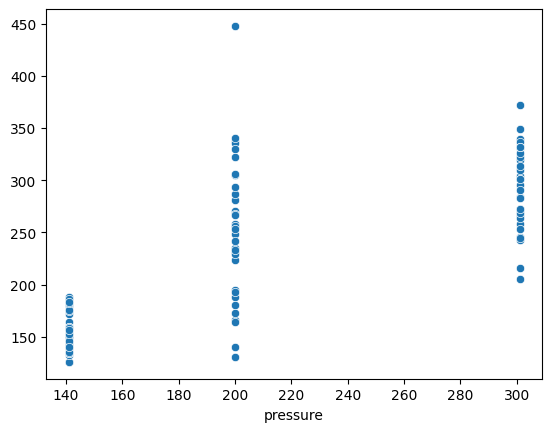

In [ ]:
model = MultiOutputRegressor(RandomForestRegressor(random_state = 0))
step = [('Scaler', MinMaxScaler()),
            ('Model', model)]
    
model_pipe = Pipeline(step)

model_pipe.fit(X_train,y_train)

y_hat = model_pipe.predict(X_test)

print(loss(y_test, y_hat))

sns.scatterplot(x = y_test['pressure'], y= y_hat[:, 1])

In [ ]:
y_test

,temperature,pressure
71,293.15,200.0
72,293.15,200.0
73,293.15,200.0
74,293.15,200.0
75,293.15,200.0
...,...,...
349,315.15,301.0
350,315.15,301.0
351,315.15,301.0
352,315.15,301.0


In [ ]:
temp = 293.15

data = test.query(f'temperature == {temp}')

y_hat = model_pipe.predict(data.drop(columns=['pressure','temperature']))

media = np.median(y_hat[: ,0 ])  
erro = 1.96 * y_hat[: ,0 ].std() / np.sqrt(data.shape[0])
upper = media + erro
lower = media - erro
print(f"Média : {media:.2f}")
print(f"Intervalo de 95% (Normal): [{lower:.2f}, {upper:.2f}]")

media = np.median(y_hat[: ,1 ])  
erro = 1.96 * y_hat[: ,1 ].std() / np.sqrt(data.shape[0])
upper = media + erro
lower = media - erro
print(f"Média : {media:.2f}")
print(f"Intervalo de 95% (Normal): [{lower:.2f}, {upper:.2f}]")

Média : 304.73
Intervalo de 95% (Normal): [302.44, 307.02]
Média : 254.66
Intervalo de 95% (Normal): [232.45, 276.88]


In [ ]:
data.head(1)

,center,amplitude,sigma,gamma,fwhm,height,temperature,pressure
71,5683.566411,0.1269,0.007352,0.044989,0.093415,0.875589,293.15,200.0


In [ ]:
mean_pred, lower, upper = bootstrap_normal_ci(y_hat[:,1])
print(f"Média Bootstrap: {mean_pred:.2f}")
print(f"Intervalo de 95% (Normal): [{lower:.2f}, {upper:.2f}]")

mean_pred, lower, upper = bootstrap_normal_ci(y_hat[:,0])
print(f"Média Bootstrap: {mean_pred:.2f}")
print(f"Intervalo de 95% (Normal): [{lower:.2f}, {upper:.2f}]")

Média Bootstrap: 252.45
Intervalo de 95% (Normal): [252.22, 252.67]
Média Bootstrap: 303.72
Intervalo de 95% (Normal): [303.69, 303.74]


Inicializando
Base de dados hitran já existe

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: hcl
  65536 bytes written to ./hcl.data
  65536 bytes written to ./hcl.data
  65536 bytes written to ./hcl.data
Header written to ./hcl.header
END DOWNLOAD
                     Lines parsed: 859
PROCESSED
{'air': 0, 'self': 1}
1.064307 seconds elapsed for abscoef; nlines = 859
P(23), 320K, 0.1atm -> 0.9999999291143813
P(22), 320K, 0.1atm -> 0.9999993748506709
P(21), 320K, 0.1atm -> 0.999983146079318
P(20), 320K, 0.1atm -> 0.9999989867422281
P(19), 320K, 0.1atm -> 0.9999754864927005
P(18), 320K, 0.1atm -> 0.999971271785926
P(17), 320K, 0.1atm -> 0.9999732438815994
P(16), 320K, 0.1atm -> 0.9999999159527837
P(15), 320K, 0.1atm -> 0.9964007025942363
P(14), 320K, 0.1atm -> 0.9999998151830293
P(13), 320K, 0.1atm -> 0.9999984111080974
P(12), 320K, 0.1atm -> 0.9999998169411675
P(11), 320K, 0.1atm -> 0.9991777181217381
P(10), 320K, 0.1atm -> 0.9999997989940884
P(9), 320K, 0.1atm -> 0.9999989242

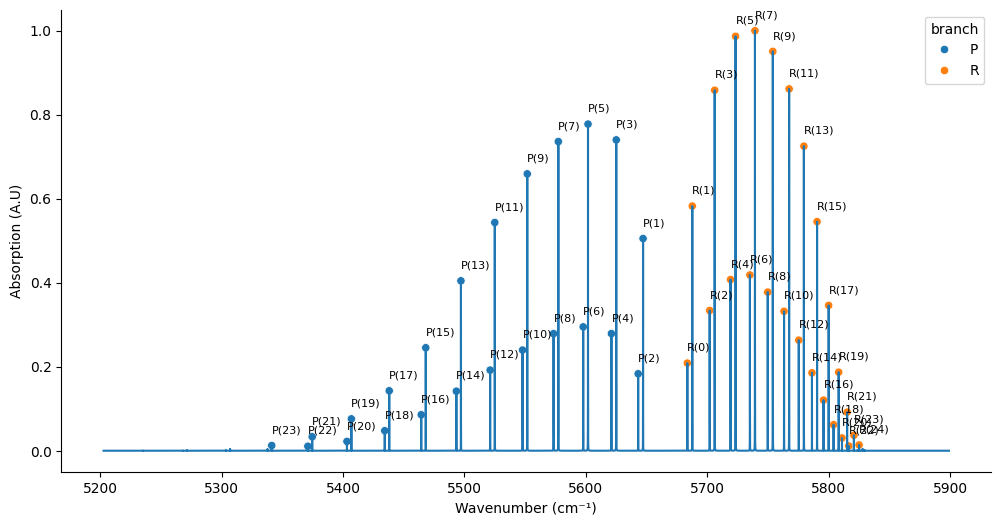

In [ ]:
pressure = 0.1
temperature = 320

s = SpectraGenerator()
s.downloadMolecule('hcl',(52,53),(5200,5900))
# Simulando o espectro
s.simulateSpectra('hcl', {'air': 0, 'self': 1}, {'l': 2, 'p': pressure, 'T': temperature})
s.spectra['absorption'] = s.spectra['absorption']/ np.max(s.spectra['absorption'])

# Organizando as linhas
lines = branchClassification(s.spectra, findPeaksParams={'height': 0.01, 'width': 1, 'distance': None},thresoldBranch=5665)
lines['pressure'] = pressure
lines['temperature'] = temperature


# Ajustando múltiplas linhas
fitted_params = multipleLineFit(s.spectra, lines, 0.01)
lines = pd.concat([lines, fitted_params], axis=1)

plotSpectrum(s.spectra, lines)

In [ ]:
lines = r2Filter(lines, 0.9)
lines = lines[['center','amplitude','sigma','gamma','fwhm','height']]

lines

,center,amplitude,sigma,gamma,fwhm,height
0,5341.321521,0.000395,4.860373e-03,0.007411,0.021287,0.013212
1,5371.060085,0.000351,4.760118e-03,0.008370,0.022600,0.010869
2,5374.629119,0.001089,4.917264e-03,0.008383,0.022925,0.033336
3,5403.253105,0.000877,4.791228e-03,0.009414,0.024350,0.024876
4,5406.878611,0.002711,4.964584e-03,0.009464,0.024758,0.075880
5,5434.375485,0.001977,4.854131e-03,0.010941,0.027007,0.049856
6,5438.055215,0.006071,5.029228e-03,0.011098,0.027580,0.150255
7,5464.412230,0.004013,4.868987e-03,0.012626,0.029918,0.090217
8,5468.142800,0.012469,1.849128e-03,0.014468,0.029623,0.270055
9,5493.349051,0.007304,4.934068e-03,0.014997,0.034197,0.141941


In [ ]:
pred = model_pipe.predict(lines)
np.median(pred[:,0]), np.median(pred[:,1])

(np.float64(293.1500000000005), np.float64(86.22949999999999))

In [ ]:
pred

array([[293.15 , 104.203],
       [293.15 ,  88.873],
       [293.15 ,  77.412],
       [293.15 ,  77.255],
       [293.15 ,  74.884],
       [293.15 ,  90.031],
       [293.15 ,  87.001],
       [293.15 ,  90.701],
       [293.15 , 108.907],
       [293.15 ,  79.168],
       [293.15 ,  83.223],
       [293.15 ,  80.731],
       [293.15 , 113.106],
       [293.15 ,  82.919],
       [304.01 ,  93.949],
       [293.35 ,  85.351],
       [304.81 ,  98.901],
       [293.15 ,  85.977],
       [304.09 ,  96.786],
       [293.15 ,  86.596],
       [303.81 ,  95.789],
       [293.15 ,  77.381],
       [295.97 ,  85.488],
       [293.15 ,  77.858],
       [302.57 ,  85.304],
       [293.15 ,  83.607],
       [313.31 ,  90.097],
       [293.15 ,  88.945],
       [314.07 , 112.513],
       [293.15 , 119.725],
       [314.33 , 121.86 ],
       [293.15 ,  78.186],
       [314.17 ,  95.1  ],
       [293.15 ,  79.774],
       [313.03 ,  79.939],
       [293.15 , 119.623],
       [293.15 , 124.026],
 